In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import SparsePCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file, n_components=500):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        
        # Use variance threshold to select features
        # selector = VarianceThreshold(threshold=var_threshold)
        # self.data = selector.fit_transform(self.data)
        
        # Use PCA to reduce the number of features
        pca = PCA(n_components=n_components)
        self.data = pca.fit_transform(self.data)
        
        # Use Sparse PCA to reduce the number of features
        # spca = SparsePCA(n_components=n_components)
        # self.data = spca.fit_transform(self.data)
        
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


In [2]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

In [3]:
batch_size = 256


In [4]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = list(idx[:split_point])
test_idx = list(idx[split_point:])

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [5]:
class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        # self.t = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        # self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu1 = nn.ReLU()
        # self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        # out = self.t(out)
        out = self.dropout(out)
        # out = self.fc3(out)
        # out = self.relu1(out)
        # out = self.dropout1(out)
        out = self.fc2(out)
        return out

In [6]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    Train_acc = []
    Val_acc = []
    Test_acc = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = list(np.concatenate([indices[:start], indices[end:]]))
        trainval_indices = list(indices[start:end])
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        # learning_rate = 0.1
        # hidden_dim = 512

        # Initialize model and transfer to GPU
        model = MoannaModel(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        Train_acc.append(train_accs[-1])
        Val_acc.append(val_accs[-1])
        Test_acc.append(test_accs[-1])
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model, Train_acc, Val_acc, Test_acc

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.3459, Train Acc=0.1181, Val Acc=0.1661, Test Acc=0.1512
Fold 1/5, Epoch 2: Train Loss=3.0869, Train Acc=0.1697, Val Acc=0.2016, Test Acc=0.1896
Fold 1/5, Epoch 3: Train Loss=2.8738, Train Acc=0.2222, Val Acc=0.2603, Test Acc=0.2505
Fold 1/5, Epoch 4: Train Loss=2.6806, Train Acc=0.2944, Val Acc=0.3153, Test Acc=0.3088
Fold 1/5, Epoch 5: Train Loss=2.5084, Train Acc=0.3511, Val Acc=0.3186, Test Acc=0.3182
Fold 1/5, Epoch 6: Train Loss=2.3697, Train Acc=0.3758, Val Acc=0.3584, Test Acc=0.3369
Fold 1/5, Epoch 7: Train Loss=2.2657, Train Acc=0.3980, Val Acc=0.3644, Test Acc=0.3547
Fold 1/5, Epoch 8: Train Loss=2.1880, Train Acc=0.4075, Val Acc=0.3591, Test Acc=0.3575
Fold 1/5, Epoch 9: Train Loss=2.1216, Train Acc=0.4235, Val Acc=0.3657, Test Acc=0.3628
Fold 1/5, Epoch 10: Train Loss=2.0652, Train Acc=0.4367, Val Acc=0.3610, Test Acc=0.3643
Fold 1/5, Epoch 11: Train Loss=2.0167, Train Acc=0.4499, Val Acc=0.3800, Test Acc=0.3827
Fold 1/

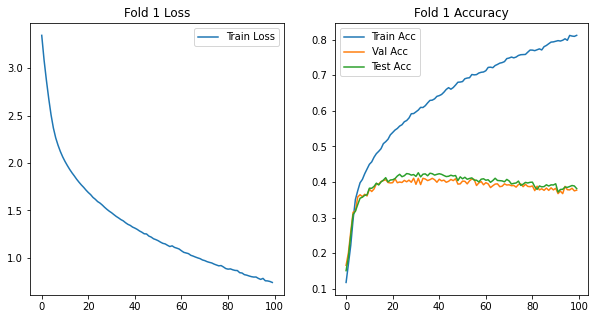

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.3402, Train Acc=0.1223, Val Acc=0.1248, Test Acc=0.1334
Fold 2/5, Epoch 2: Train Loss=3.0816, Train Acc=0.1667, Val Acc=0.1621, Test Acc=0.1735
Fold 2/5, Epoch 3: Train Loss=2.8801, Train Acc=0.2158, Val Acc=0.2236, Test Acc=0.2271
Fold 2/5, Epoch 4: Train Loss=2.6935, Train Acc=0.2881, Val Acc=0.2720, Test Acc=0.2721
Fold 2/5, Epoch 5: Train Loss=2.5235, Train Acc=0.3283, Val Acc=0.3327, Test Acc=0.3188
Fold 2/5, Epoch 6: Train Loss=2.3859, Train Acc=0.3711, Val Acc=0.3221, Test Acc=0.3061
Fold 2/5, Epoch 7: Train Loss=2.2839, Train Acc=0.3825, Val Acc=0.3647, Test Acc=0.3435
Fold 2/5, Epoch 8: Train Loss=2.2007, Train Acc=0.4064, Val Acc=0.3877, Test Acc=0.3533
Fold 2/5, Epoch 9: Train Loss=2.1351, Train Acc=0.4165, Val Acc=0.3765, Test Acc=0.3597
Fold 2/5, Epoch 10: Train Loss=2.0769, Train Acc=0.4348, Val Acc=0.3888, Test Acc=0.3669
Fold 2/5, Epoch 11: Train Loss=2.0276, Train Acc=0.4471, Val Acc=0.3949, Test Acc=0.3721
Fold 2/

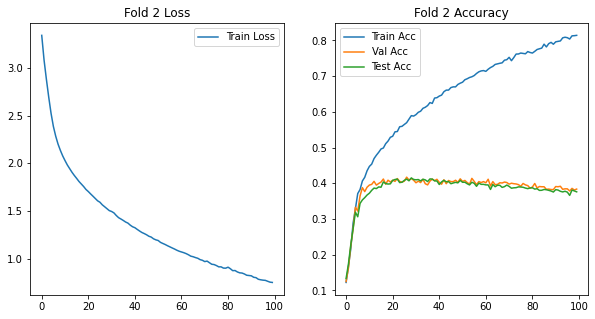

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.3429, Train Acc=0.1185, Val Acc=0.1523, Test Acc=0.1444
Fold 3/5, Epoch 2: Train Loss=3.0817, Train Acc=0.1660, Val Acc=0.1726, Test Acc=0.1777
Fold 3/5, Epoch 3: Train Loss=2.8791, Train Acc=0.2274, Val Acc=0.2393, Test Acc=0.2298
Fold 3/5, Epoch 4: Train Loss=2.6943, Train Acc=0.2891, Val Acc=0.2955, Test Acc=0.2854
Fold 3/5, Epoch 5: Train Loss=2.5274, Train Acc=0.3409, Val Acc=0.3452, Test Acc=0.3200
Fold 3/5, Epoch 6: Train Loss=2.3960, Train Acc=0.3664, Val Acc=0.3517, Test Acc=0.3295
Fold 3/5, Epoch 7: Train Loss=2.2961, Train Acc=0.3820, Val Acc=0.3614, Test Acc=0.3415
Fold 3/5, Epoch 8: Train Loss=2.2155, Train Acc=0.3983, Val Acc=0.3928, Test Acc=0.3580
Fold 3/5, Epoch 9: Train Loss=2.1518, Train Acc=0.4124, Val Acc=0.3903, Test Acc=0.3633
Fold 3/5, Epoch 10: Train Loss=2.0978, Train Acc=0.4288, Val Acc=0.3949, Test Acc=0.3635
Fold 3/5, Epoch 11: Train Loss=2.0481, Train Acc=0.4390, Val Acc=0.4170, Test Acc=0.3833
Fold 3/

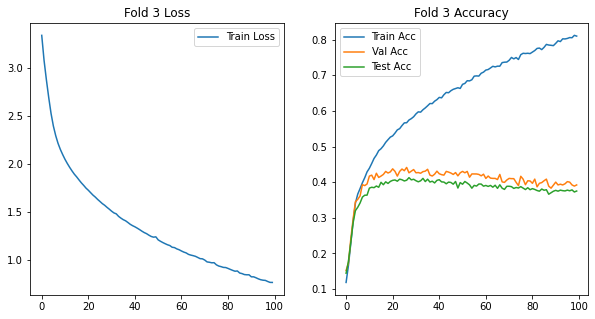

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.3507, Train Acc=0.1219, Val Acc=0.1530, Test Acc=0.1527
Fold 4/5, Epoch 2: Train Loss=3.0943, Train Acc=0.1654, Val Acc=0.1766, Test Acc=0.1771
Fold 4/5, Epoch 3: Train Loss=2.8838, Train Acc=0.2108, Val Acc=0.2256, Test Acc=0.2276
Fold 4/5, Epoch 4: Train Loss=2.6983, Train Acc=0.2887, Val Acc=0.2968, Test Acc=0.2883
Fold 4/5, Epoch 5: Train Loss=2.5310, Train Acc=0.3411, Val Acc=0.3143, Test Acc=0.3123
Fold 4/5, Epoch 6: Train Loss=2.3953, Train Acc=0.3683, Val Acc=0.3248, Test Acc=0.3279
Fold 4/5, Epoch 7: Train Loss=2.2899, Train Acc=0.3908, Val Acc=0.3379, Test Acc=0.3411
Fold 4/5, Epoch 8: Train Loss=2.2102, Train Acc=0.4018, Val Acc=0.3490, Test Acc=0.3517
Fold 4/5, Epoch 9: Train Loss=2.1464, Train Acc=0.4145, Val Acc=0.3522, Test Acc=0.3574
Fold 4/5, Epoch 10: Train Loss=2.0889, Train Acc=0.4307, Val Acc=0.3581, Test Acc=0.3611
Fold 4/5, Epoch 11: Train Loss=2.0399, Train Acc=0.4451, Val Acc=0.3685, Test Acc=0.3752
Fold 4/

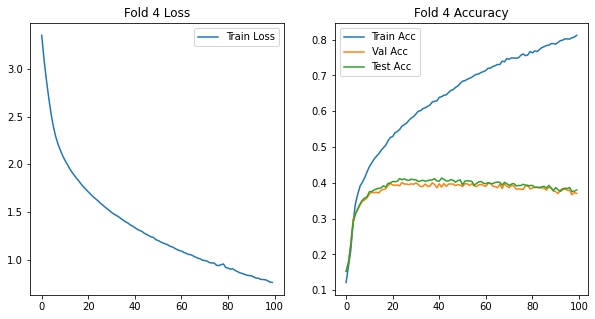

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.3338, Train Acc=0.1306, Val Acc=0.1332, Test Acc=0.1600
Fold 5/5, Epoch 2: Train Loss=3.0578, Train Acc=0.1740, Val Acc=0.1666, Test Acc=0.1903
Fold 5/5, Epoch 3: Train Loss=2.8474, Train Acc=0.2220, Val Acc=0.2197, Test Acc=0.2346
Fold 5/5, Epoch 4: Train Loss=2.6625, Train Acc=0.2897, Val Acc=0.2771, Test Acc=0.2809
Fold 5/5, Epoch 5: Train Loss=2.4971, Train Acc=0.3317, Val Acc=0.3346, Test Acc=0.3170
Fold 5/5, Epoch 6: Train Loss=2.3677, Train Acc=0.3696, Val Acc=0.3489, Test Acc=0.3317
Fold 5/5, Epoch 7: Train Loss=2.2677, Train Acc=0.3905, Val Acc=0.3182, Test Acc=0.3186
Fold 5/5, Epoch 8: Train Loss=2.1919, Train Acc=0.4058, Val Acc=0.3594, Test Acc=0.3476
Fold 5/5, Epoch 9: Train Loss=2.1286, Train Acc=0.4148, Val Acc=0.3588, Test Acc=0.3571
Fold 5/5, Epoch 10: Train Loss=2.0723, Train Acc=0.4289, Val Acc=0.3771, Test Acc=0.3654
Fold 5/5, Epoch 11: Train Loss=2.0252, Train Acc=0.4420, Val Acc=0.3573, Test Acc=0.3508
Fold 5/

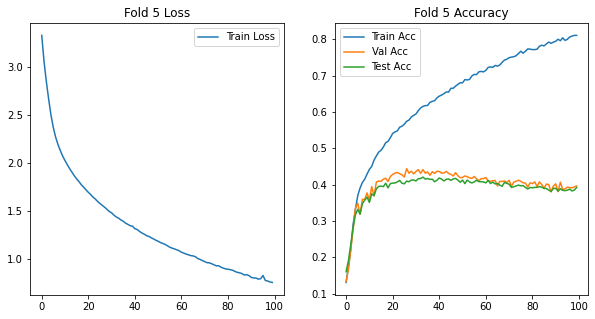

In [16]:
num_epochs = 100
k = 5
learning_rate = 0.5
hidden_dim = 256

Model, Train_acc, Val_acc, Test_acc = k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device=device, shuffle=True)

In [17]:
TRAIN_acc = np.mean(Train_acc)
print(f"{TRAIN_acc:.4f}")

0.8116


In [18]:
VAL_acc = np.mean(Val_acc)
print(f"{VAL_acc:.4f}")

0.3840


In [19]:
TEST_acc = np.mean(Test_acc)
print(f"{TEST_acc:.4f}")

0.3810
